<a href="https://colab.research.google.com/github/pmb06d/computer_vision_fashionMNIST/blob/master/fashion_mnist_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistics

Importing Keras and helper libraries as well as the Fashion MNIST from Keras.

A lot of code is adapted from the [Keras tutorial](https://www.tensorflow.org/guide/keras)


## Packages, data, and Google SDK authentication

In [0]:
# package to save the models, might not need it if you are on colab
# !pip install h5py pyyaml

In [0]:
# Install PyDrive and authenticate Google Account

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.2MB/s 


In [0]:
# Most of this code is adapted from the amazing Keras tutorial
# https://www.tensorflow.org/guide/keras

# Import the packages
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from tensorflow import set_random_seed
from keras import optimizers

# Helper libraries
import pandas as pd
import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import time


print(tf.__version__)

1.13.1


Using TensorFlow backend.


In [0]:
# Import the fashion MNIST dataset from keras

fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# A list with the class names to replace the numeric labels

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Initial Exploration

Exploring the data set and defining some functions for plotting the images

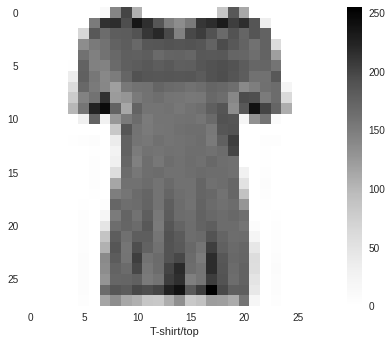

In [0]:
# inspecting the individual images and its label
image_index = 10

# creates a new figure
plt.figure()

# Display an image
plt.imshow(train_images[image_index])

# Create the gradient bar to the side
plt.colorbar()

# elimnate the grid so we can see the image
plt.grid(False)

# Print the label below the plot
plt.xlabel(class_names[train_labels[image_index]])

plt.show()

<function matplotlib.pyplot.show>

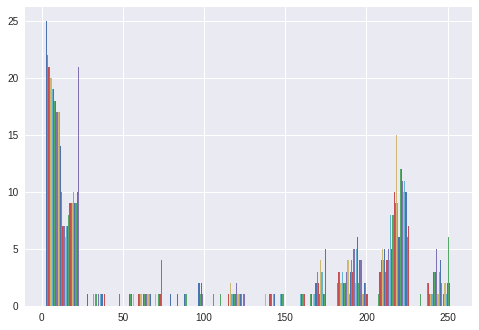

In [0]:
# The numbers on each pixel range from

plt.hist(train_images[0]);
plt.show

In [0]:
# re-scale the values for the neural net to values from 0 to 1

train_images = train_images / 255.0

test_images = test_images / 255.0

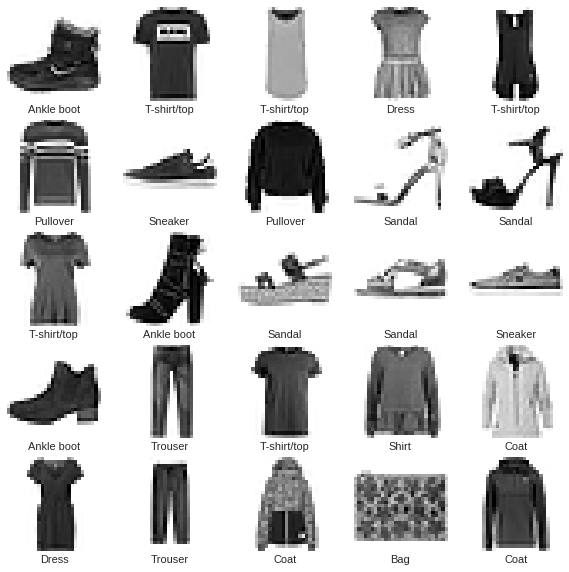

In [0]:
# a 5 x 5 matrix of plots with the first 25 images

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)     #the last parameter 'i+1' is telling it where to plot, for matplotlib it starts at 1 (top left)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Pre-Processing for Sklearn

In [0]:
start_time = time.time()

# Flattening the numpy arrays into a dataframe to use with sklearn
# This one takes a while ~ 35 seconds

train_images2 = train_images
test_images2 = test_images

train_df = [list(train_images2[i].flatten()) for i in range(len(train_images2))]
train_df = pd.DataFrame(train_df, columns=[str(i) for i in range(len(train_df[i]))])


test_df = [list(test_images2[i].flatten()) for i in range(len(test_images2))]
test_df = pd.DataFrame(test_df, columns=[str(i) for i in range(len(test_df[i]))])


print("Processing time: %s seconds" % (time.time() - start_time))
print('Training set dimensions:',train_df.shape)
print("Training labels:",len(train_labels))
print('Testing set dimensions:',test_df.shape)
print("Testing labels:",len(test_labels))

Processing time: 19.725517511367798 seconds
Training set dimensions: (60000, 784)
Training labels: 60000
Testing set dimensions: (10000, 784)
Testing labels: 10000


## Helper functions

Grouping all the graphing functions at the beggining to clean up the notebook

In [0]:
# Some functions to plot the results from the TensorFlow tutorial

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [0]:
# Some Frankenstein functions from  the TensorFlow tutorials and my own home cooking

# Plot out mislabeled images

def plot_mislabeled(modelName, cnn=False):
  
  # get the predicted labels
  
  if cnn == False:
    predictions = modelName.predict(test_images)
  else:
    predictions = modelName.predict(test_images_cnn)
  
  pred_labels = [np.argmax(i) for i in predictions]
  test_labels_temp = list(test_labels)
  
  # using pandas to get the mislabeled
  mislabels = pd.DataFrame(list(zip(test_labels_temp,pred_labels)))

  mislabels['Match'] = mislabels.iloc[:,0] == mislabels.iloc[:,1]

  mislabels.reset_index(inplace=True)

  mislabels = mislabels.loc[mislabels['Match']==False,:]

  mislabeled = list(mislabels['index'])
  
  # Plot a 5 by 5 matrix of mislabeled test images, their predicted label, and the true label
  # The true label is in blue and the incorrect predictions in red
  num_rows = 5
  num_cols = 5
  num_images = num_rows*num_cols
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))


  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[mislabeled], test_labels[mislabeled], test_images[mislabeled])

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[mislabeled], test_labels[mislabeled])

  plt.show()


In [0]:
# Print the accuracy by category

# Another good article for validation plots
# https://github.com/cmasch/zalando-fashion-mnist/blob/master/Simple_Convolutional_Neural_Network_Fashion-MNIST.ipynb


def category_acc(modelName, cnn=False):
  
  # get the predicted labels
  
  if cnn == False:
    predictions = modelName.predict(test_images)
  else:
    predictions = modelName.predict(test_images_cnn)
  
  pred_labels = [np.argmax(i) for i in predictions]
  test_labels_temp = list(test_labels)
  
  mislabels2 = pd.DataFrame(list(zip(test_labels_temp,pred_labels)), columns = ['Actual','Predicted'])

  mislabels2['Match'] = mislabels2.iloc[:,0] == mislabels2.iloc[:,1]

  class_dict = dict(enumerate(class_names))
  mislabels2 = mislabels2.replace({"Actual": class_dict})

  mislabels2 = mislabels2[['Actual','Match']].groupby(['Actual']).sum()/mislabels2[['Actual','Match']].groupby(['Actual']).count()

  del mislabels2.index.name

  mislabels2 = mislabels2.sort_values(by=['Match'],ascending = False)
  
  return(mislabels2)
  

In [0]:
# A slightly different function for the flat dataset

def category_acc2(modelName):
  
  # get the predicted labels
  
  predictions = modelName.predict(X_test)
  pred_labels = predictions
  
  test_labels_temp = list(Y_test)
  
  mislabels2 = pd.DataFrame(list(zip(test_labels_temp,pred_labels)), columns = ['Actual','Predicted'])

  mislabels2['Match'] = mislabels2.iloc[:,0] == mislabels2.iloc[:,1]

  class_dict = dict(enumerate(class_names))
  mislabels2 = mislabels2.replace({"Actual": class_dict})

  mislabels2 = mislabels2[['Actual','Match']].groupby(['Actual']).sum()/mislabels2[['Actual','Match']].groupby(['Actual']).count()

  del mislabels2.index.name

  mislabels2 = mislabels2.sort_values(by=['Match'],ascending = False)
  
  return(mislabels2)

In [0]:
# straight out of the Keras docs. Plot the accuracy and validation over the training epochs
# https://keras.io/visualization/

def epoch_acc(model_var):
  
    # Plot training & validation accuracy values
    plt.plot(model_var.history['acc'])
    plt.plot(model_var.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(model_var.history['loss'])
    plt.plot(model_var.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

  

# Neural Networks


## MLP model #1

A neural net with 2 fully connected layers. The first one uses a rectified linear unit activation function, the second one uses a sigmoid activation function and the output layer uses softmax to output the probability for each category. The adam optimizer worked the best with this particular architecture

### Definition

In [0]:
# The first layer flattens the 28x28 numpy arrays into 1-dimensional arrays

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(510, activation=tf.nn.relu),
    keras.layers.Dense(510, activation='sigmoid'),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 510)               400350    
_________________________________________________________________
dense_1 (Dense)              (None, 510)               260610    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5110      
Total params: 666,070
Trainable params: 666,070
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile the model
# at least in the small experiments I did, a higher learning rate has a huge impact on performance

# different attempts:
# keras.optimizers.Adam(lr=0.001)
# keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
# keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

# an interesting article on optimizer performance for image classification:
# https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/

# the adam optimizer without specifying learning rate showed the highest score on the test set

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

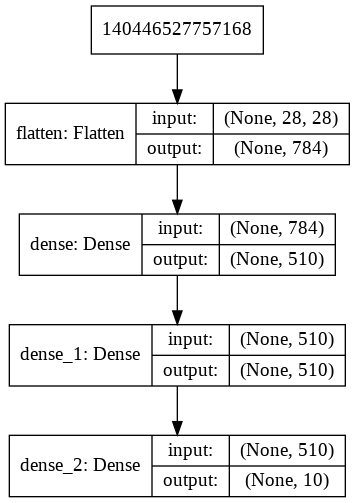

In [0]:
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

### Results

In [0]:
seed(50)
set_random_seed(50)

start_time = time.time()

modelOut = model.fit(train_images, train_labels, validation_split=0.33, epochs=25)

mlp1_time = time.time() - start_time

print("--- %s seconds ---" % (time.time() - start_time),"\n")

Train on 40199 samples, validate on 19801 samples
Epoch 1/25
40199/40199 [==============================] - 8s 208us/sample - loss: 0.4992 - acc: 0.8171 - val_loss: 0.3881 - val_acc: 0.8563
Epoch 2/25
40199/40199 [==============================] - 8s 187us/sample - loss: 0.3702 - acc: 0.8620 - val_loss: 0.4358 - val_acc: 0.8403
Epoch 3/25
40199/40199 [==============================] - 8s 188us/sample - loss: 0.3316 - acc: 0.8764 - val_loss: 0.3611 - val_acc: 0.8678
Epoch 4/25
40199/40199 [==============================] - 8s 191us/sample - loss: 0.3044 - acc: 0.8851 - val_loss: 0.3344 - val_acc: 0.8787
Epoch 5/25
40199/40199 [==============================] - 7s 187us/sample - loss: 0.2824 - acc: 0.8926 - val_loss: 0.3310 - val_acc: 0.8803
Epoch 6/25
40199/40199 [==============================] - 7s 186us/sample - loss: 0.2646 - acc: 0.9002 - val_loss: 0.3090 - val_acc: 0.8895
Epoch 7/25
40199/40199 [==============================] - 7s 185us/sample - loss: 0.2512 - acc: 0.9052 - val_l

In [0]:
start_time = time.time()

mlp1_test_loss, mlp1_test_acc = model.evaluate(test_images, test_labels)
mlp1_train_acc = np.max((modelOut.history['acc']))

print("\n","Train time: %s seconds" % (mlp1_time),sep="")
print("Test time: %s seconds" % (time.time() - start_time),sep="")

print('Test accuracy:', mlp1_test_acc)
print('Train accuracy:', mlp1_train_acc)

10000/10000 [==============================] - 1s 68us/sample - loss: 0.4425 - acc: 0.8836

Train time: 196.05652284622192 seconds
Test time: 0.6884031295776367 seconds
Test accuracy: 0.8836
Train accuracy: 0.92179704


### Interpretation

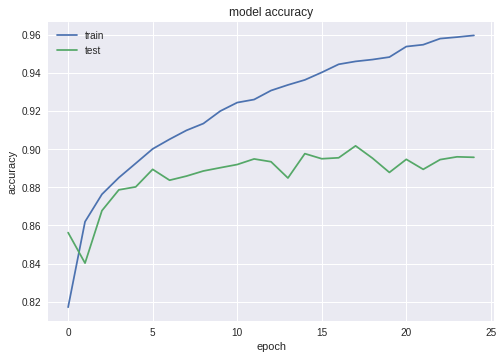

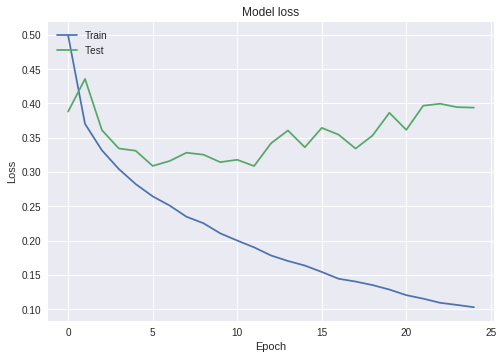

In [0]:
epoch_acc(modelOut)

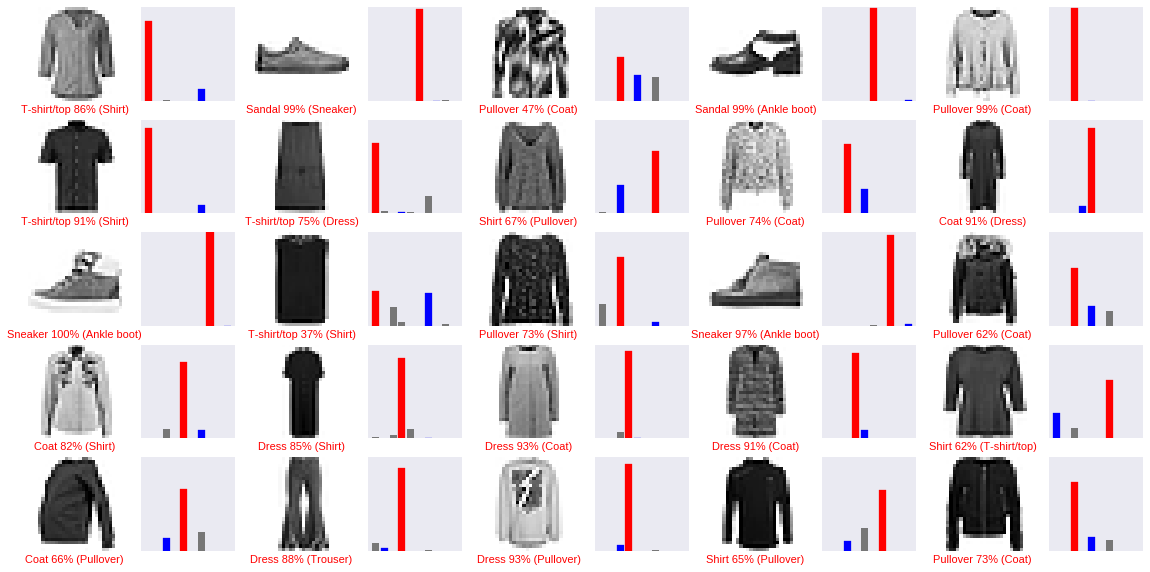

In [0]:
plot_mislabeled(model)

In [0]:
category_acc(model)

,Match
Trouser,0.981
Sneaker,0.976
Bag,0.968
Ankle boot,0.954
Sandal,0.933
Dress,0.878
T-shirt/top,0.862
Coat,0.807
Pullover,0.787
Shirt,0.690


In [0]:
# Save the model to Google Drive

model.save('MLP1.h5')
model_file = drive.CreateFile({'parents':[{u'id': '1ePgC5mOJZrinUsUH01u_TOz544CI8sxI'}],'title' : 'MLP1.h5'})
model_file.SetContentFile('MLP1.h5')
model_file.Upload()

## MLP model #2

A neural net with 2 fully connected layers and 2 drop out layers. Similar to the previous MLP, the first dense layer uses a rectified linear unit activation function and the second one uses a sigmoid activation function. The output layer uses softmax to output the probability for each category. 


### Activation function exploration

For this second MLP I wanted to try some iteration with the activation functions and plot out the difference. At the end it seems that when evaluated individually, they all eventually converge. However compared to no activation function, any of them is better, at least for this dataset


------ None activation
Train on 40199 samples, validate on 19801 samples
Epoch 1/25
40199/40199 [==============================] - 3s 70us/sample - loss: 0.6029 - acc: 0.7922 - val_loss: 0.5101 - val_acc: 0.8216
Epoch 2/25
40199/40199 [==============================] - 2s 60us/sample - loss: 0.4714 - acc: 0.8366 - val_loss: 0.4999 - val_acc: 0.8219
Epoch 3/25
40199/40199 [==============================] - 2s 50us/sample - loss: 0.4416 - acc: 0.8450 - val_loss: 0.4747 - val_acc: 0.8375
Epoch 4/25
40199/40199 [==============================] - 2s 49us/sample - loss: 0.4390 - acc: 0.8445 - val_loss: 0.4765 - val_acc: 0.8266
Epoch 5/25
40199/40199 [==============================] - 2s 49us/sample - loss: 0.4230 - acc: 0.8522 - val_loss: 0.4328 - val_acc: 0.8499
Epoch 6/25
40199/40199 [==============================] - 2s 49us/sample - loss: 0.4166 - acc: 0.8541 - val_loss: 0.4312 - val_acc: 0.8498
Epoch 7/25
40199/40199 [==============================] - 2s 49us/sample - loss: 0.4167 - ac

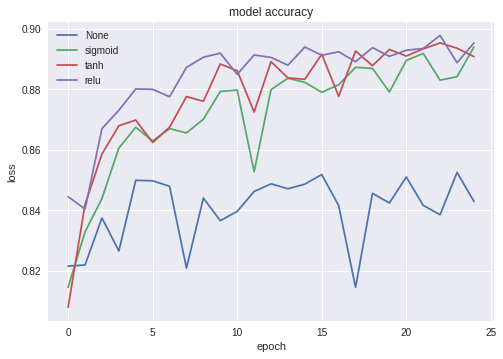

In [0]:
# Adapted from this source: https://github.com/shudima/notebooks/blob/master/Activation%20Functions.ipynb
# Make sure to scroll to the bottom for the graph!

batch_size = 128
epochs = 25

for activation in [None, 'sigmoid', 'tanh', 'relu']:
    start_time = time.time()
    model_temp = keras.Sequential()
    model_temp.add(keras.layers.Flatten(input_shape=(28, 28)))
    model_temp.add(keras.layers.Dense(512, activation=activation, input_shape=(784,)))
    model_temp.add(keras.layers.Dense(10, activation='softmax'))
    model_temp.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    print('\n','------ ',activation,' activation',sep="")
    history = model_temp.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.33)   # Can also do validation_data=(x_test, y_test)
    print('\n','--- %s seconds ---' % (time.time() - start_time),'\n')
    
    plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['None', 'sigmoid', 'tanh', 'relu'], loc='upper left')

### Definition

In [0]:
model3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(1000, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(500, activation=tf.nn.sigmoid),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation=tf.nn.softmax),
])

# Take a look at the model summary
model3.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5010      
Total params: 1,290,510
Tra

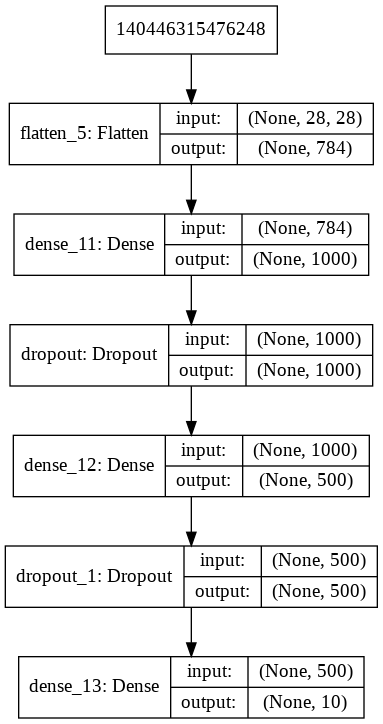

In [0]:
# Plot model graph
plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
# Compile the model

model3.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Results

In [0]:
start_time = time.time()

seed(50)
set_random_seed(50)

model3Out = model3.fit(train_images, train_labels, validation_split=0.33, epochs=25)

mlp2_time = time.time() - start_time

print("\n","--- %s seconds ---" % (time.time() - start_time),sep="")

Train on 40199 samples, validate on 19801 samples
Epoch 1/25
40199/40199 [==============================] - 10s 244us/sample - loss: 0.6075 - acc: 0.7761 - val_loss: 0.4192 - val_acc: 0.8448
Epoch 2/25
40199/40199 [==============================] - 9s 231us/sample - loss: 0.4544 - acc: 0.8325 - val_loss: 0.3925 - val_acc: 0.8531
Epoch 3/25
40199/40199 [==============================] - 9s 229us/sample - loss: 0.4192 - acc: 0.8461 - val_loss: 0.3608 - val_acc: 0.8670
Epoch 4/25
40199/40199 [==============================] - 9s 229us/sample - loss: 0.3931 - acc: 0.8549 - val_loss: 0.3782 - val_acc: 0.8588
Epoch 5/25
40199/40199 [==============================] - 9s 228us/sample - loss: 0.3783 - acc: 0.8600 - val_loss: 0.3675 - val_acc: 0.8613
Epoch 6/25
40199/40199 [==============================] - 9s 235us/sample - loss: 0.3645 - acc: 0.8662 - val_loss: 0.3319 - val_acc: 0.8792
Epoch 7/25
40199/40199 [==============================] - 10s 239us/sample - loss: 0.3586 - acc: 0.8657 - val

In [0]:
start_time = time.time()

mlp2_test_loss, mlp2_test_acc = model3.evaluate(test_images, test_labels)
mlp2_train_acc = np.max((model3Out.history['acc']))

print("\n","Train time: %s seconds" % (mlp2_time),sep="")
print("Test time: %s seconds" % (time.time() - start_time),sep="")

print('Test accuracy:', mlp2_test_acc)
print('Train accuracy:', mlp2_train_acc)

10000/10000 [==============================] - 1s 76us/sample - loss: 0.3277 - acc: 0.8853

Train time: 242.59723472595215 seconds
Test time: 0.7703218460083008 seconds
Test accuracy: 0.8853
Train accuracy: 0.8736188


### Interpretation

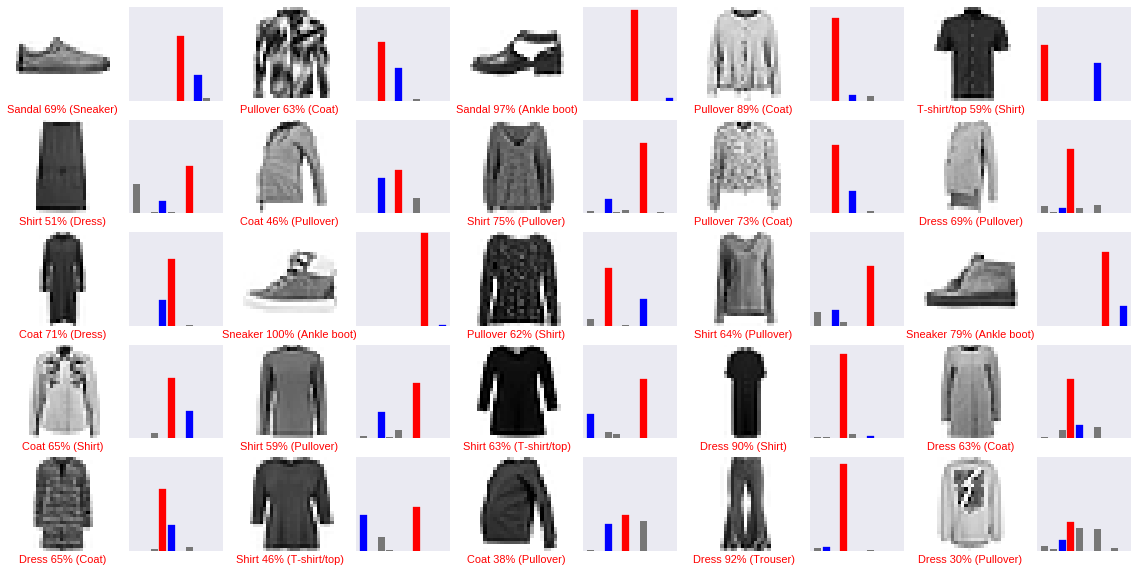

In [0]:
plot_mislabeled(model3)

In [0]:
category_acc(model3)

,Match
Bag,0.978
Sneaker,0.972
Trouser,0.962
Ankle boot,0.956
Sandal,0.951
Dress,0.903
Coat,0.850
T-shirt/top,0.813
Pullover,0.756
Shirt,0.712


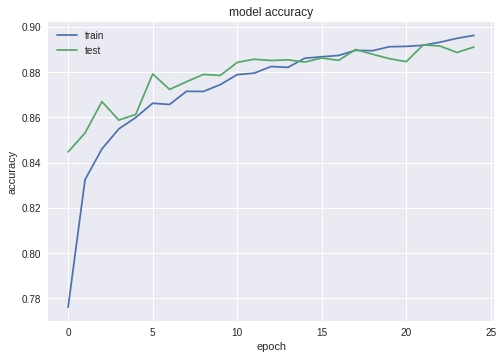

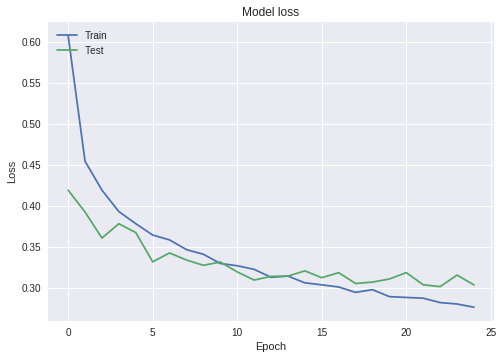

In [0]:
epoch_acc(model3Out)

In [0]:
# Save the model to Google Drive

model3.save('MLP2.h5')
model3_file = drive.CreateFile({'parents':[{u'id': '1ePgC5mOJZrinUsUH01u_TOz544CI8sxI'}],'title' : 'MLP2.h5'})
model3_file.SetContentFile('MLP2.h5')
model3_file.Upload()

## CNN model #1

I really liked this explanation for this model. 

>*The first convolution layer gives 32 channels as output (the first argument, which reads 32), after convolving the image with 5x5 filters (second argument). The padding is “same”, which means the layer is sufficiently zero padded so that each of the 32 channel outputs have exact same height and width as the input. Therefore, the first output reads (None, 28, 28, 32), with the second, third and the fourth dimension representing height, width and number of channels respectively.*

>*We now move to the maxpool layer. The shape of max-pooling layer is 2x2 (the first argument). We haven’t specified any stride size, and it therefore defaults to the size of the input. This means that we will make a jump of size 2 each along the height and the width dimension. For each 2x2 block the maxpool layer jumps to, it generates 1 output which is the maximum of the 4 cells of the block it spans across. This way, we are able to achieve a reduction in the size of the image. Due to this, the output of the maxpool layer consists of 32 channels, each channel being a 14x14 matrix of max-pooled data. Therefore, the output shape is (None, 14, 14, 32).*

>*After another set of similar convolution and max-pooling layers, the input has now been transformed into a tensor with shape (batch size, 7, 7, 64). The further layers of our network are fully connected layers. These layers require the input to be a vector, whereas our data is a 3d cube of size 7x7x64. Therefore, we apply a Flatten layer. This takes the transformed data, which is in the form of a cube, and rearranges them into a flat vector having just one dimension. The number of elements in this 1d vector would be 7x7x64 = 3136.*

>*The final 2 layers are dense layers, the output of shape of each is the same as the number of neurons in each dense layers (provided as the first argument).*

NOTE: I modified the architechture of the model a little bit but it is mostly the same, mainly by adding some activation functions to the convolution layer.

[Source](https://pravarmahajan.github.io/fashion/)



### Pre-processing


In [0]:
# Some additional preprocessing to get into the correct shape for the convolution layer

train_images_cnn = train_images.reshape([-1, 28, 28, 1])
test_images_cnn = test_images.reshape([-1, 28, 28, 1])

print('Original shape:',train_images.shape)
print('New shape:',train_images_cnn.shape)

Original shape: (60000, 28, 28)
New shape: (60000, 28, 28, 1)


### Definition

In [0]:
# The first layer must define the input shape in Keras

model2 = keras.Sequential([
    keras.layers.Conv2D(32, (5, 5), activation='relu', padding="same", input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

# Take a look at the model summary
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              3212288   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

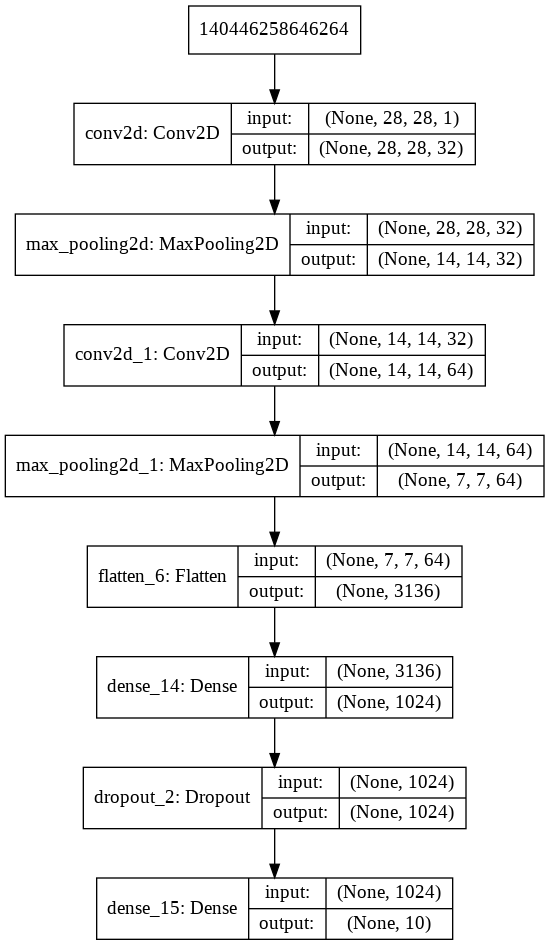

In [0]:
# Plot model graph
plot_model(model2, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
# Compile the model

model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Results

In [0]:
start_time = time.time()

seed(50)
set_random_seed(50)

model2Out = model2.fit(train_images_cnn, train_labels, validation_split=0.33, epochs=25)

cnn_time = time.time() - start_time

print("\n","--- %s seconds ---" % (time.time() - start_time),sep="")

Train on 40199 samples, validate on 19801 samples
Epoch 1/25
40199/40199 [==============================] - 16s 394us/sample - loss: 0.4502 - acc: 0.8372 - val_loss: 0.3147 - val_acc: 0.8848
Epoch 2/25
40199/40199 [==============================] - 14s 342us/sample - loss: 0.2950 - acc: 0.8920 - val_loss: 0.2674 - val_acc: 0.8996
Epoch 3/25
40199/40199 [==============================] - 14s 339us/sample - loss: 0.2523 - acc: 0.9057 - val_loss: 0.2798 - val_acc: 0.8977
Epoch 4/25
40199/40199 [==============================] - 14s 339us/sample - loss: 0.2184 - acc: 0.9186 - val_loss: 0.2389 - val_acc: 0.9126
Epoch 5/25
40199/40199 [==============================] - 15s 373us/sample - loss: 0.1899 - acc: 0.9290 - val_loss: 0.2409 - val_acc: 0.9173
Epoch 6/25
40199/40199 [==============================] - 15s 370us/sample - loss: 0.1700 - acc: 0.9356 - val_loss: 0.2506 - val_acc: 0.9170
Epoch 7/25
40199/40199 [==============================] - 15s 365us/sample - loss: 0.1514 - acc: 0.9438 

In [0]:
start_time = time.time()

cnn_test_loss, cnn_test_acc = model2.evaluate(test_images_cnn, test_labels)
cnn_train_acc = np.mean((model2Out.history['acc']))

print("\n","Train time: %s seconds" % (cnn_time),sep="")
print("Test time: %s seconds" % (time.time() - start_time),sep="")

print('Test accuracy:', cnn_test_acc)
print('Train accuracy:', cnn_train_acc)

10000/10000 [==============================] - 1s 113us/sample - loss: 0.5009 - acc: 0.9142

Train time: 365.8508388996124 seconds
Test time: 1.1367056369781494 seconds
Test accuracy: 0.9142
Train accuracy: 0.95747155


### Interpretation

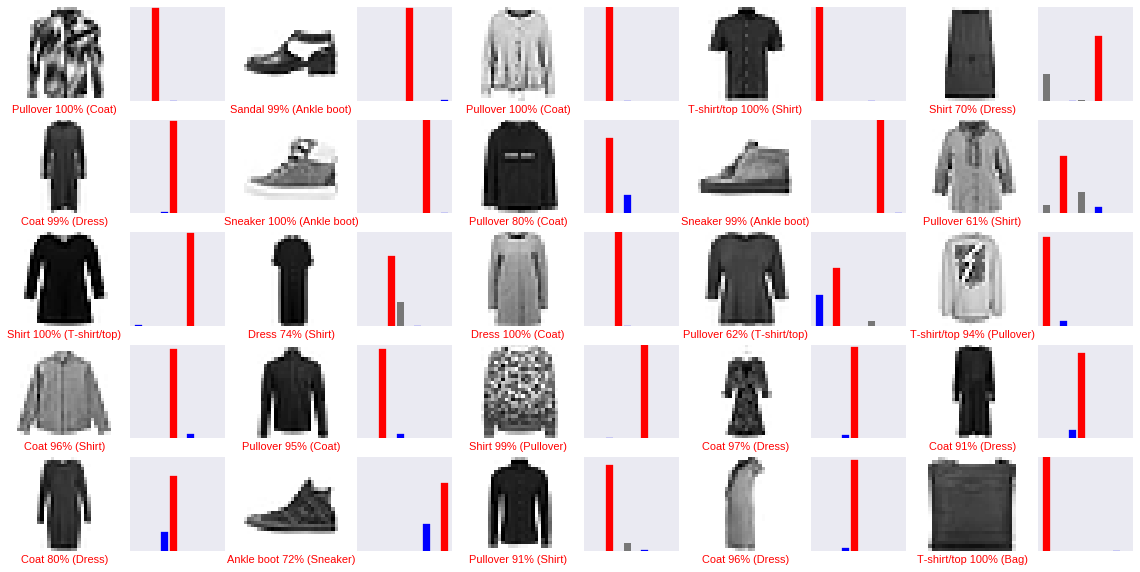

In [0]:
plot_mislabeled(model2, cnn=True)

In [0]:
category_acc(model2, cnn=True)

,Match
Trouser,0.988
Sandal,0.981
Bag,0.980
Sneaker,0.980
Ankle boot,0.956
Dress,0.909
Pullover,0.894
Coat,0.869
T-shirt/top,0.861
Shirt,0.724


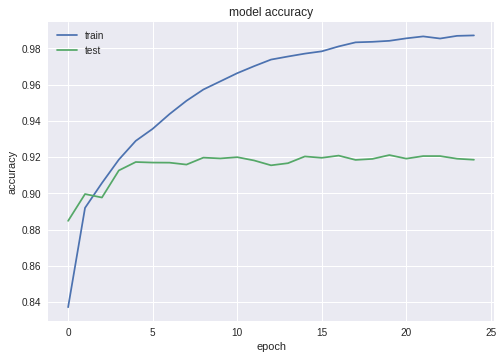

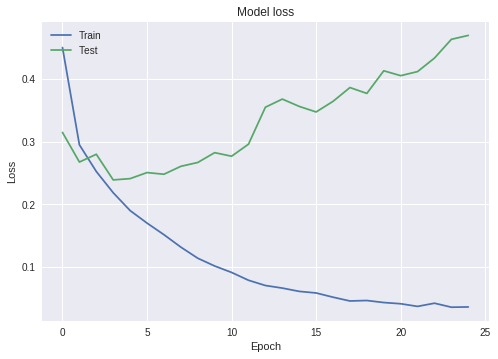

In [0]:
epoch_acc(model2Out)

In [0]:
# Save the model to Google Drive

model2.save('CNN1.h5')
model2_file = drive.CreateFile({'parents':[{u'id': '1ePgC5mOJZrinUsUH01u_TOz544CI8sxI'}],'title' : 'CNN1.h5'})
model2_file.SetContentFile('CNN1.h5')
model2_file.Upload()

## CNN model #2

A simpler CNN with only one convolution layer, this architecture also includes a dropout layer after the pooling layer and a smaller (when compared to the first CNN) fully connected layer before the output layer.

### Definition

In [0]:
# In this article the author claims that he got 94% on the test set! I want to try his architechture ato see
# Source: https://www.kaggle.com/danialk/range-of-cnns-on-fashion-mnist-dataset

model4 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

batch_size = 512

# Take a look at the model summary
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile the model

model4.compile(keras.optimizers.Adam(lr=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Results

In [0]:
start_time = time.time()

seed(50)
set_random_seed(50)

model4Out = model4.fit(train_images_cnn, train_labels, batch_size=batch_size, validation_split=0.33, epochs=25)

cnn2_time = time.time() - start_time

print("\n","--- %s seconds ---" % (time.time() - start_time),sep="")

Train on 40199 samples, validate on 19801 samples
Epoch 1/25
40199/40199 [==============================] - 2s 58us/sample - loss: 0.6961 - acc: 0.7654 - val_loss: 0.4554 - val_acc: 0.8373
Epoch 2/25
40199/40199 [==============================] - 2s 44us/sample - loss: 0.4122 - acc: 0.8572 - val_loss: 0.3779 - val_acc: 0.8684
Epoch 3/25
40199/40199 [==============================] - 2s 44us/sample - loss: 0.3635 - acc: 0.8735 - val_loss: 0.3496 - val_acc: 0.8778
Epoch 4/25
40199/40199 [==============================] - 2s 44us/sample - loss: 0.3322 - acc: 0.8838 - val_loss: 0.3271 - val_acc: 0.8850
Epoch 5/25
40199/40199 [==============================] - 2s 44us/sample - loss: 0.3131 - acc: 0.8902 - val_loss: 0.3082 - val_acc: 0.8911
Epoch 6/25
40199/40199 [==============================] - 2s 44us/sample - loss: 0.2908 - acc: 0.8971 - val_loss: 0.2972 - val_acc: 0.8953
Epoch 7/25
40199/40199 [==============================] - 2s 44us/sample - loss: 0.2800 - acc: 0.9009 - val_loss: 0.

In [0]:
start_time = time.time()

cnn2_test_loss, cnn2_test_acc = model4.evaluate(test_images_cnn, test_labels)
cnn2_train_acc = np.mean((model4Out.history['acc']))

print("\n","Train time: %s seconds" % (cnn2_time),sep="")
print("Test time: %s seconds" % (time.time() - start_time),sep="")

print('Test accuracy:', cnn2_test_acc)
print('Train accuracy:', cnn2_train_acc)

10000/10000 [==============================] - 1s 89us/sample - loss: 0.2739 - acc: 0.9041

Train time: 46.71572256088257 seconds
Test time: 0.8962445259094238 seconds
Test accuracy: 0.9041
Train accuracy: 0.9106356


### Interpretation

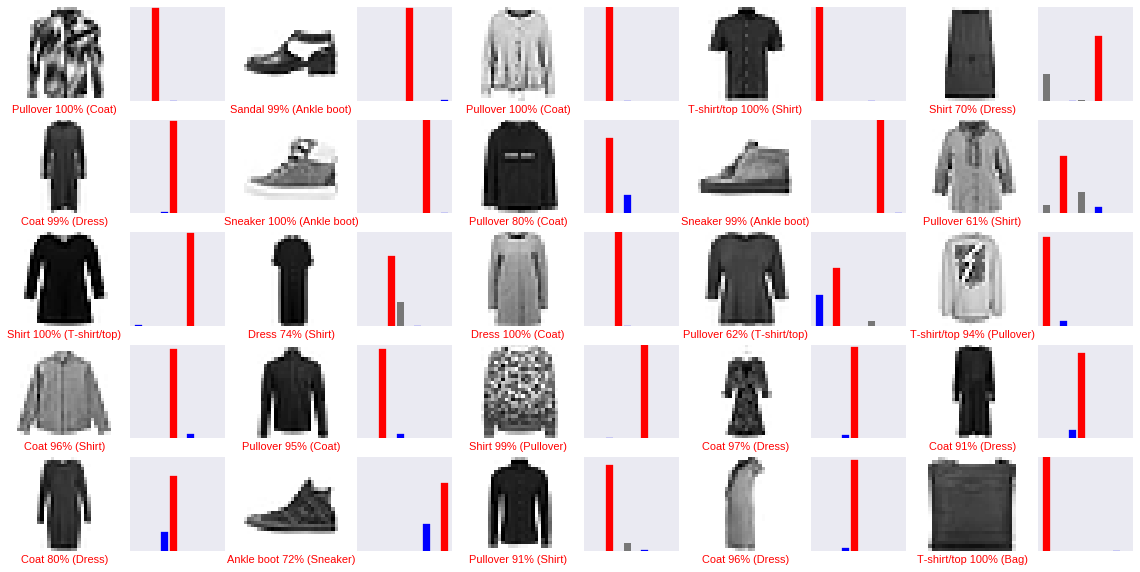

In [0]:
plot_mislabeled(model2, cnn=True)

In [0]:
category_acc(model2, cnn=True)

,Match
Trouser,0.988
Sandal,0.981
Bag,0.980
Sneaker,0.980
Ankle boot,0.956
Dress,0.909
Pullover,0.894
Coat,0.869
T-shirt/top,0.861
Shirt,0.724


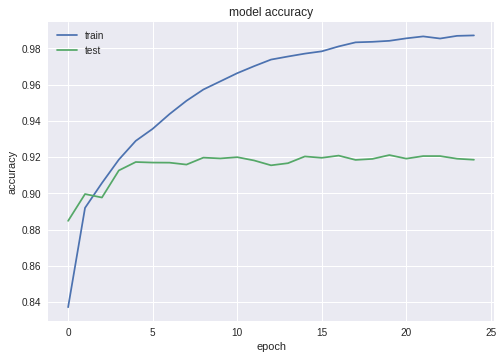

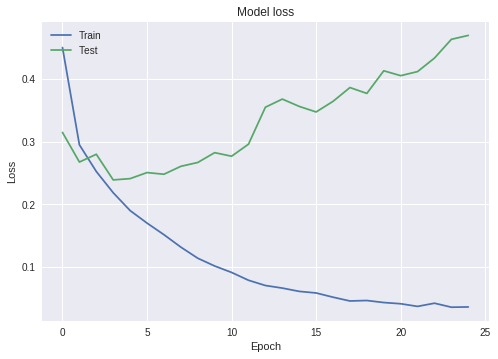

In [0]:
epoch_acc(model2Out)

In [0]:
# Save the model to Google Drive

model4.save('CNN2.h5')
model4_file = drive.CreateFile({'parents':[{u'id': '1ePgC5mOJZrinUsUH01u_TOz544CI8sxI'}],'title' : 'CNN2.h5'})
model4_file.SetContentFile('CNN2.h5')
model4_file.Upload()

# Sklearn classifiers

In [0]:
# it was taking literally hours to run just logistic regression so, i'm going to test these models with a smaller subset and then pick the best one to test the full thing
X = train_df.values
Y = train_labels
X_test = test_df.values
Y_test = test_labels

# some random indexes to downsample
import random

random.seed(50)

rand_list_train = random.sample(range(len(Y)), 20000)
rand_list_test = random.sample(range(len(Y_test)), 4000)

X = X[rand_list_train]
Y = Y[rand_list_train] 

X_test = X_test[rand_list_test]
Y_test = Y_test[rand_list_test]

## Logistic Regression

In [0]:
# Logistic Regression

start_time = time.time()

seed(50)

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X, Y)

lr_score = lr_model.score(X_test, Y_test)
lr_score2 = lr_model.score(X, Y)
lr_time = time.time() - start_time

print("\n","Time: %s seconds" % (time.time() - start_time), sep="")
print("Accuracy train:",lr_score2)
print("Accuracy test:",lr_score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Time: 74.3061089515686 seconds
Accuracy train: 0.89115
Accuracy test: 0.83675


## k Nearest Neighbors

In [0]:
# KNN

start_time = time.time()

seed(50)

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X, Y)

knn_score = knn_model.score(X_test, Y_test)
knn_score2 = knn_model.score(X, Y)
knn_time = time.time() - start_time

print("Time: %s seconds" % (time.time() - start_time))
print("Accuracy train:",knn_score2)
print("Accuracy test:",knn_score)

Time: 731.8755533695221 seconds
Accuracy train: 0.885
Accuracy test: 0.836


## Naive Bayes

In [0]:
# Gaussian Naive Bayes

start_time = time.time()

seed(50)

from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X, Y)

nb_score = nb_model.score(X_test, Y_test)
nb_score2 = nb_model.score(X, Y)
nb_time = time.time() - start_time

print("Time: %s seconds" % (time.time() - start_time))
print("Accuracy train:",nb_score2)
print("Accuracy test:",nb_score)

Time: 1.8331141471862793 seconds
Accuracy train: 0.56535
Accuracy test: 0.5695


## Random Forests

In [0]:
# Random Forests

start_time = time.time()

seed(50)

from sklearn.ensemble import RandomForestClassifier 
rf_model = RandomForestClassifier(n_estimators = 25)
rf_model.fit(X, Y)

rf_score = rf_model.score(X_test, Y_test)
rf_score2 = rf_model.score(X, Y)
rf_time = time.time() - start_time

print("Time: %s seconds" % (time.time() - start_time))
print("Accuracy train:",rf_score2)
print("Accuracy test:",rf_score)

Time: 7.83498740196228 seconds
Accuracy train: 0.99965
Accuracy test: 0.8565


## Gradient Boosting Classifier

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

seed(50)

clf_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.005, subsample=0.7, min_samples_leaf=10, max_depth=7, random_state=11)
clf_model.fit(X, Y)

clf_score = clf_model.score(X_test, Y_test)
clf_score2 = clf_model.score(X, Y)
clf_time = time.time() - start_time

print("Time: %s seconds" % (time.time() - start_time))
print("Accuracy train:",clf_score2)
print("Accuracy test:",clf_score)


Time: 1725.7176570892334 seconds
Accuracy train: 0.91825
Accuracy test: 0.84275


## Support Vector Machines

In [0]:
# SVM

start_time = time.time()

seed(50)

from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X, Y)

svm_score = svm_model.score(X_test, Y_test)
svm_score2 = svm_model.score(X, Y)
svm_time = time.time() - start_time

print("\n","Time: %s seconds" % (time.time() - start_time), sep="")
print("Accuracy train:",svm_score2)
print("Accuracy test:",svm_score)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Time: 380.74330282211304 seconds
Accuracy train: 0.84105
Accuracy test: 0.8295


# Algorithm Comparison

In [0]:
names = ['MLP #1','MLP #2','CNN #1','CNN #2', 'LOGISTIC REG', 'KNN' ,'NAIVE BAYES', 'RANDOM FOREST', 'GRADIENT BOOSTING', 'SVM' ]

time = [mlp1_time, mlp2_time, cnn_time, cnn2_time, lr_time, knn_time, nb_time, rf_time, clf_time, svm_time]

train_accuracy = [mlp1_train_acc,
                  mlp2_train_acc,
                  cnn_train_acc,
                  cnn2_train_acc,
                  lr_score2,
                  knn_score2,
                  nb_score2,
                  rf_score2,
                  clf_score2,
                  svm_score2]

test_accuracy = [mlp1_test_acc,
                 mlp2_test_acc,
                 cnn_test_acc,
                 cnn2_test_acc,
                 lr_score,
                 knn_score,
                 nb_score,
                 rf_score,
                 clf_score,
                 svm_score]

lab9_metrics = pd.DataFrame(list(zip(names, time,train_accuracy, test_accuracy)),columns= ['Name','Train_Time','Train_Acc','Test_Acc'])
lab9_metrics

,Name,Train_Time,Train_Acc,Test_Acc
0,MLP #1,196.056523,0.921797,0.88360
1,MLP #2,242.597235,0.873619,0.88530
2,CNN #1,365.850839,0.957472,0.91420
3,CNN #2,46.715723,0.910636,0.90410
4,LOGISTIC REG,74.306040,0.891150,0.83675
5,KNN,731.875507,0.885000,0.83600
6,NAIVE BAYES,1.833066,0.565350,0.56950
7,RANDOM FOREST,7.834944,0.999650,0.85650
8,GRADIENT BOOSTING,1725.717600,0.918250,0.84275
9,SVM,380.743245,0.841050,0.82950


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


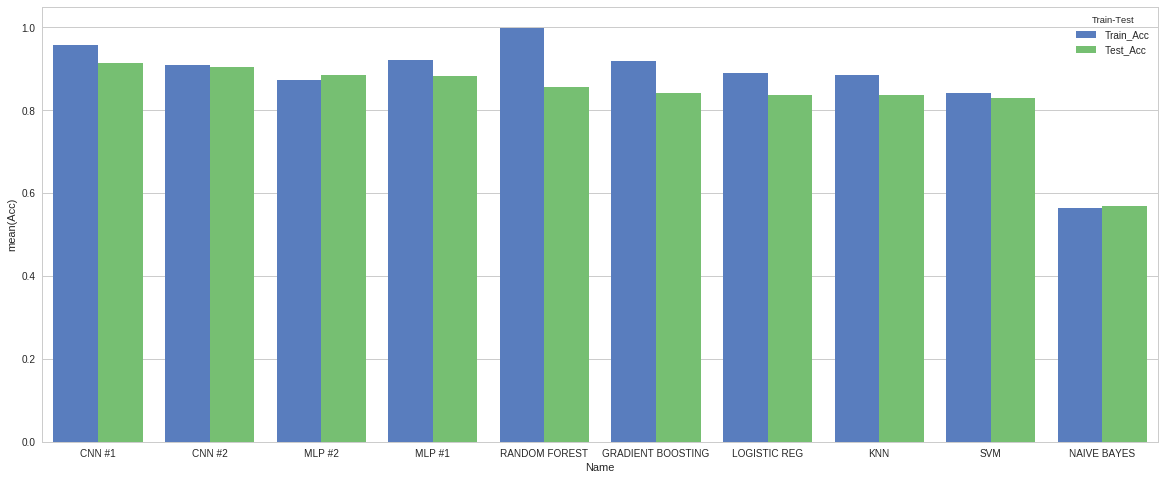

In [0]:
# Plot the train/test accuracy of each algoritm to see which ones overfit more

df = pd.melt(lab9_metrics[['Name','Train_Acc','Test_Acc']], id_vars='Name', var_name='Train-Test', value_name='Acc').reset_index().sort_values('Acc', ascending=False)

sns.set(style="whitegrid")

plt.figure(figsize=(20, 8))

sorting_values = df.loc[df['Train-Test']=='Test_Acc',['Name','Acc']]

g = sns.barplot(x="Name", y="Acc", hue="Train-Test", data=df, order=sorting_values['Name'], palette="muted");

g

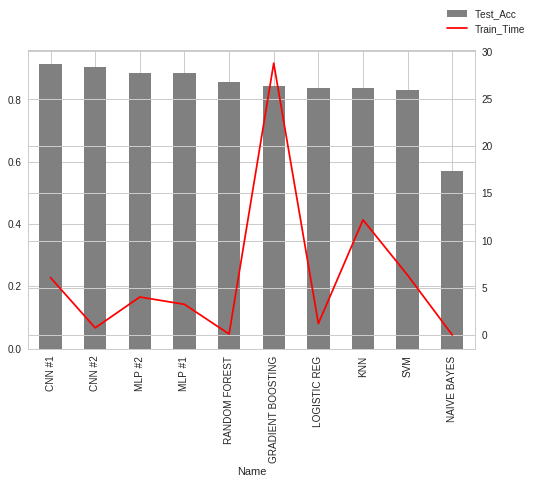

In [0]:
# plot the testing accuracy againt the time it took to build

df2 = lab9_metrics[['Name','Train_Time','Test_Acc']].sort_values('Test_Acc', ascending=False)
df2['Train_Time'] = df2['Train_Time']/60

ax = df2.plot.bar(x="Name", y="Test_Acc",legend=False,color='gray')
ax2 = ax.twinx()
df2.plot(x="Name", y="Train_Time", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [0]:
# compile the category accuracy from the neural nets

mlp_df = category_acc(model)
mlp2_df = category_acc(model3)
cnn_df = category_acc(model2, cnn=True)
cnn2_df = category_acc(model4, cnn=True)

In [0]:

# compile the category accuracy from the sklearn classifiers

start_time = time.time()

lr_df = category_acc2(lr_model)
knn_df = category_acc2(knn_model)
nb_df = category_acc2(nb_model)
rf_df = category_acc2(rf_model)
clf_df = category_acc2(clf_model)
svm_df = category_acc2(svm_model)

print("\n","--- %s seconds ---" % (time.time() - start_time),sep="")

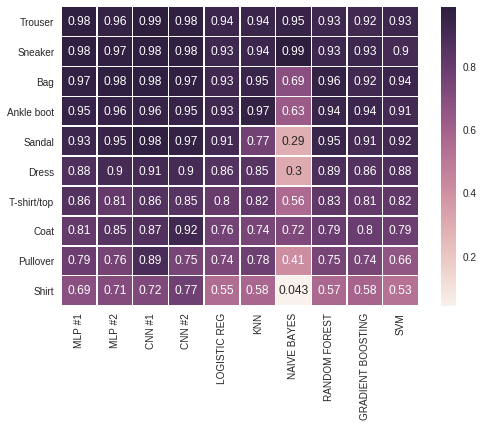

In [0]:
cat_acc = mlp_df.join(mlp2_df, lsuffix='_MLP1', rsuffix='MLP2')

cat_acc = cat_acc.join(cnn_df, lsuffix='_caller', rsuffix='CNN1')
cat_acc = cat_acc.join(cnn2_df, lsuffix='CNN1', rsuffix='_CNN2')

cat_acc = cat_acc.join(lr_df, lsuffix='_caller', rsuffix='_match')
cat_acc = cat_acc.join(knn_df, lsuffix='_caller', rsuffix='_match')
cat_acc = cat_acc.join(nb_df, lsuffix='_caller', rsuffix='_match')
cat_acc = cat_acc.join(rf_df, lsuffix='_caller', rsuffix='_match')
cat_acc = cat_acc.join(clf_df, lsuffix='_caller', rsuffix='_match')
cat_acc = cat_acc.join(svm_df, lsuffix='_caller', rsuffix='_match')

cat_acc.columns = ['MLP #1','MLP #2','CNN #1','CNN #2','LOGISTIC REG', 'KNN' ,'NAIVE BAYES', 'RANDOM FOREST', 'GRADIENT BOOSTING', 'SVM']

ax = sns.heatmap(cat_acc,linewidths=.5, annot=True)
ax